# Mini Project 2. App Reviews Sentiment Analysis

### Yuening Li

This project build a Recurrent Neural Network (RNN) model for predicting App reviews sentiment into either "Positive", or "Negative". 

The training set for this model would be the training set used in 2015 paper by Maalej and Nabil, ‘On the automatic classification of app reviews’, available at (https://mast.informatik.uni-hamburg.de/app-review-analysis/).

The Testing data set used for prediction are the pre-processed app review data in size of 384.

## 1.1 Dependencies 
First, let's install dependencies, and import the relevant packages we'll need for this project.

In [0]:
# Import Tensorflow 2.0
%tensorflow_version 2.x
import tensorflow as tf 

# Import all remaining packages
import numpy as np
import os
import matplotlib.pyplot as plt
import time
import functools
from IPython import display as ipythondisplay
from tqdm import tqdm
import string
import re
import pandas as pd
import json
from pandas.io.json import json_normalize

# Check that we are using a GPU, if not switch runtimes
#   using Runtime > Change Runtime Type > GPU
assert len(tf.config.list_physical_devices('GPU')) > 0

## 1.2 Dataset

Fetch the data from google drive


In [2]:
# mount google drive to colab
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/gdrive')

Drive not mounted, so nothing to flush and unmount.
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
ROOT_PATH ='/content/gdrive/My Drive/App_Reviews'
TRAIN_PATH = ROOT_PATH + "/all.json"

with open(TRAIN_PATH, encoding='utf-8-sig') as json_file:
    json_data = json.load(json_file)
train_data = pd.DataFrame.from_dict(json_normalize(json_data), orient='columns')[['comment','rating']]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  import sys


In the meta data of app reviews, sentiment could be measured by star rating, a numeric value between 1 and 5 given by the user. 
 



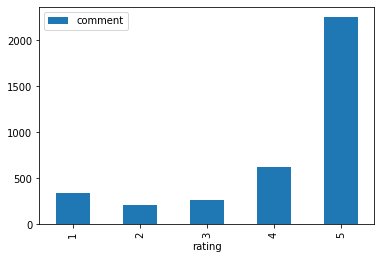

In [4]:
train_data.groupby('rating').count().plot.bar()

In the bar plot above, we could see that we have unblanced distribution of reviews sentiment. 

Next, we convert the rating to either 1 for "positive" or  0 for "negative". Notice to labels need to be binary encoded to use in model. To balance out, we keep the 5 star reviews as "positive" and 1 or 2 star as "negative".

In [0]:
#  train_data = train_data[(train_data['rating'] <= 2) | ((train_data['rating'] == 5) & (len(train_data['comment'])>200))]
train_data = train_data.loc[(train_data['rating'] <=2) | ((train_data['rating'] == 5))]
train_data["sentiment"] = np.where(train_data.rating ==5, 1, 0)


#### reviews pre-processing:
Apply the following:
- drop duplicate.
- Remove the numbers and non-ASCII characters.
- Remove punctuations.
- Remove multiple characters if they occur more than 2 times continuously.

In [0]:
import nltk
nltk.download('words')
words = set(nltk.corpus.words.words())

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [0]:
# drop duplicate
train_data.drop_duplicates(subset= ["comment","sentiment"],inplace = True)
train_data["id"] = range(len(train_data.index))

train_data["comment"] = train_data["comment"].astype(str)
train_data["new_text"] = train_data["comment"]
def clean_sent(sent):
    return " ".join(w for w in nltk.wordpunct_tokenize(sent) \
     if w.lower() in words or not w.isalpha())
def remove_num(s): return ''.join([i for i in s if not i.isdigit()])
def remove_non_ascii(s): return ''.join([i if 32 < ord(i) < 126 else " " for i in s])
def remove_punctuation(s): return ''.join([p for p in s if p not in string.punctuation])
def remove_multiple_chars(s): return re.sub(r'(.)\1+', r'\1\1', s)
new_comment_list =[]
for row in train_data.itertuples():
    each_text = getattr(row, "new_text")
    index = int(getattr(row, "id"))
    #   instead of checking if the row has non-english reviews, remove all words that are non-english, and if the whole sentence is non english, the wholse sentence would become "", and would be removed for less than two or less numbers
    # remove_words = clean_sent(each_text)
    #remove the non-ascii characters
    non_ascii = remove_non_ascii(each_text)
    non_num = remove_num(non_ascii)
    #remove the punctuations
    non_punct = remove_punctuation(non_num)
    #remove more than 2 times continuously characters
    final_value= remove_multiple_chars(non_punct)
    new_comment_list.append(final_value)
train_data['new_text'] = new_comment_list
count = train_data['new_text'].str.split().str.len()
train_data =train_data[~(count<=2)]

Inspect our Training dataset

In [0]:
train_data = train_data[['new_text','sentiment']]
train_data.rename(columns={'new_text': 'comment'}, inplace=True)

In [8]:
pd.set_option('max_colwidth', 800)
train_data.head(5)

,comment,sentiment
0,Besides the occasional crash this is an amazing product with tons of potential depending on how you work with it,1
1,This could be a great app if it was predictable but it is full of bugs and is unpredictable if you are able to check in take a screen shot of your boarding pass or print a backup copy because you may not be able to access it when you need it most,0
2,I cant open since the last updates Popups go crazy on the iPhone Im uninstalling,0
3,Use to love this app but its not working after new update Pages wont scroll up or downnone of the different tabs workits frozen Please fix ASAP,0
5,This app serves its purpose for me perfectly except for the mobile deposit wont work It keeps saying cant find endorsement After calling PNC multiple times about this still no fix,0


In [9]:
train_data.groupby("sentiment").count()

,comment
sentiment,
0,495
1,1615


In [10]:
print("Our train_data contain", len(train_data[train_data['sentiment']==0]), " negative reviews and ", len(train_data[train_data['sentiment']==1]), "positive reviews.")

Our train_data contain 495  negative reviews and  1615 positive reviews.


## 1.3 Process the dataset for the learning task


RNN requires array as input type. So we need convert our text-based comment into numerical representation. 

More specifically, we want to generate a 2D array, with as many rows as number of reviews, and as many columns as a fixed length. 

We use keras libaray to achieve this. 
`fit_on_texts` creates a word_index dictionary with  vocabulary index based on word frequency. Every word gets a unique integer value. 
`texts_to_sequences` Transforms  a list of words to a list of integers using word_index dictionary.
`pad_sequences` turn all integer list to a fixed specific length, by either padding with 0s for short reviews and truncate long reviews.

In [11]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

t  = Tokenizer()
comments = train_data['comment'].values
t.fit_on_texts(comments)
sequences = t.texts_to_sequences(comments)
train_pad = pad_sequences(sequences, maxlen=100, padding='post')

Using TensorFlow backend.


Visualize dictionary from word to unique index.

In [12]:
print(list(t.word_index.items())[:10])

[('i', 1), ('the', 2), ('to', 3), ('it', 4), ('and', 5), ('app', 6), ('a', 7), ('this', 8), ('is', 9), ('my', 10)]


visualize generated 2d array

In [13]:
print(train_pad[:10,:10])

[[ 993    2 1530  302    8    9   47  109  452   23]
 [   8  128   36    7   16    6   45    4   42 2172]
 [   1   53   95  143    2  158  272 1533   88  994]
 [  20    3   13    8    6   26   22   30  230  133]
 [   8    6 2178   22 2179   11   29  755  842   11]
 [1537  329  171  844  344  121  756   51   25  627]
 [ 171    3   36  303   42  125 2185 2186   17   92]
 [ 302  302  302  302  302   41    4    0    0    0]
 [   2  540    6  685    9   24 2188   67 2189    4]
 [   8   20    3   36    7   16    6   15  136  144]]


split training set into two set of training and valid set

In [0]:
from sklearn.model_selection import train_test_split
# split the training set into two set of training and valid/testing set 
# in propportion of 0.85:0.15
train_comments, valid_comments, train_labels, test_labels =\
train_test_split(train_pad, train_data['sentiment'].values, test_size=0.4, random_state=2020)

In [17]:
print("Train shpae", train_comments.shape, "Test shape", valid_comments.shape )

Train shpae (1266, 100) Test shape (844, 100)


## 1.4 The Recurrent Neural Network (RNN) model

Now we can define and train a simple RNN model on app reviews dataset

We'll be using `tf.keras.Sequential` to define the model. Five layers are used to define the model:

* `tf.keras.layers.Embedding`: This is the input layer, with input parameter of `vocab_size` = tokenizer dictionary length+1, `embedding_dim` =128 dimentions use to represent each word, `input_length`=length of train_padding.
* `tf.keras.layers.LSTM`: Our LSTM network, with 128 units. 
* `tf.keras.layers.Dropout`: The dropout layer, prevent overfitting.
* `tf.keras.layers.Dense` and `tf.keras.layers.Activation`: The output layer, with sigmoid activation function.



### Define the RNN model

Now, we will define a function that we will use to actually build the model.

Try Model 2. LSTM

Define the RNN model within the `build_model` function, and then call the function just defined to instantiate the model


In [0]:
### Defining the RNN Model ###
def build_model(vocab_size, embedding_dim,words_limit,rnn_units):
  rnn_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim,input_length=words_limit),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Activation('sigmoid')
  ])

  return rnn_model

rnn_model = build_model(len(t.word_index)+1, 128,100, rnn_units=128)

In [49]:
rnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 128)          609408    
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 741,121
Trainable params: 741,121
Non-trainable params: 0
_________________________________________________________________


### Train and test the RNN model

Now, as before, we can define the loss function, optimizer, and metrics through the `compile` method. Compile the CNN model with an Adam optimizer with loss function of `binary_crossentropy`

In [0]:
rnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Build LearningRateScheduler to have learning rate change in each epoch.

In [0]:
EPOCHS = 20

start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.00005 
rampup_epochs = 5
sustain_epochs = 0
exp_decay = .8

def lrfn(epoch):
  if epoch < rampup_epochs:
    return (max_lr - start_lr)/rampup_epochs * epoch + start_lr
  elif epoch < rampup_epochs + sustain_epochs:
    return max_lr
  else:
    return (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=True)

Then we can train our RNN using the `fit` method via the Keras API.

In [51]:
history2 = rnn_model.fit(train_comments, train_labels, batch_size=32, epochs=20, validation_data=(valid_comments, test_labels),callbacks=[lr_callback])


Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/20
40/40 [==============================] - 1s 27ms/step - loss: 0.6836 - accuracy: 0.7449 - val_loss: 0.6792 - val_accuracy: 0.7524 - lr: 1.0000e-05

Epoch 00002: LearningRateScheduler reducing learning rate to 1.8000000000000004e-05.
Epoch 2/20
40/40 [==============================] - 1s 18ms/step - loss: 0.6695 - accuracy: 0.7733 - val_loss: 0.6623 - val_accuracy: 0.7559 - lr: 1.8000e-05

Epoch 00003: LearningRateScheduler reducing learning rate to 2.6000000000000002e-05.
Epoch 3/20
40/40 [==============================] - 1s 17ms/step - loss: 0.6451 - accuracy: 0.7709 - val_loss: 0.6288 - val_accuracy: 0.7583 - lr: 2.6000e-05

Epoch 00004: LearningRateScheduler reducing learning rate to 3.4000000000000007e-05.
Epoch 4/20
40/40 [==============================] - 1s 17ms/step - loss: 0.5775 - accuracy: 0.7701 - val_loss: 0.5413 - val_accuracy: 0.7583 - lr: 3.4000e-05

Epoch 00005: LearningRateScheduler reduc

Plot the model accuracy and model Loss

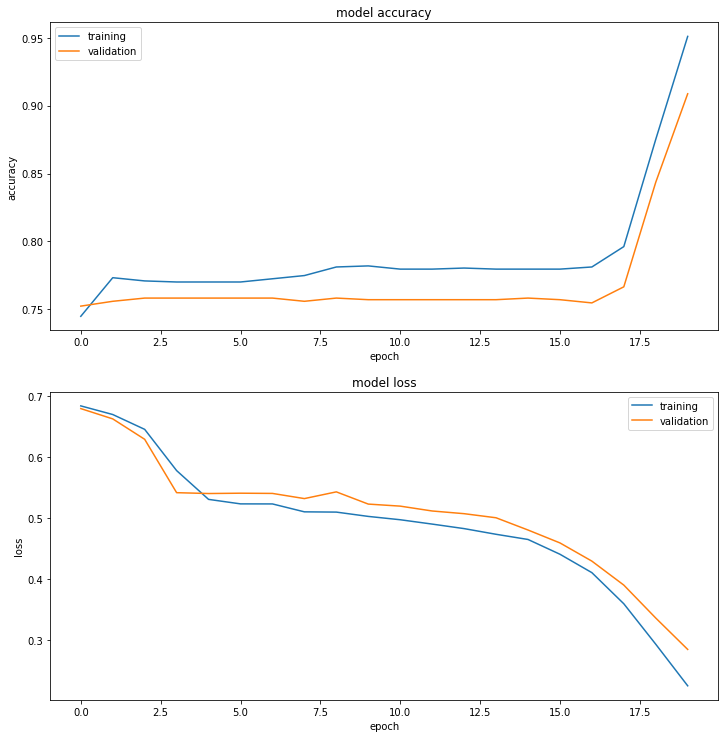

In [53]:
def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

plt.subplots(figsize=(10,10))
plt.tight_layout()
display_training_curves(history2.history['accuracy'], history2.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history2.history['loss'], history2.history['val_loss'], 'loss', 212)

Model accuracy, Validation Accuracy goes up and loss goes down. Looks good!

After training the rnn model for 20 epochs, We have obtained a 0.95 accuracy on training set, and a 0.91 accuracy on validation set 

## 1.5 Prediction using the RNN model

Now, we can use our trained RNN model to predict the sentiments for a new set of app reviews.

Recall our The Testing data set used for prediction are the newly pre-processed app review data in size of 384. It also include customer star rating from 1 to 5

In [0]:
TEST_PATH = ROOT_PATH + "/Dataset3.csv"
test_data = pd.read_csv(TEST_PATH)[['processed_text','score']]

Before predict on our rnn model, Apply the same data processing to our test reviews to get 2d array format

In [0]:
test_comments = test_data['processed_text'].values
test_sequences = t.texts_to_sequences(test_comments)
test_pad = pad_sequences(test_sequences, maxlen=100, padding='post')

Apply `predict_classes` to predict on our rnn_model

In [0]:
predictions = rnn_model.predict_classes(test_pad)

Add sentiment column to the dataframe and Randomly sample 10 reviews and Visualize the result.

In [0]:
test_data["sentiment"] = np.where(predictions ==1, "Postive", "Negative")

In [110]:
pd.set_option('max_colwidth', 800)
test_data.sample(n = 5)

,processed_text,score,sentiment
196,This Game you to buy Premium as soon as you load it on However you can get a 3 day free trial but it still your It like a good game due to graphics but I would not recommend it,1,Negative
66,because you have good,5,Postive
104,i love this Great start and meditation in,5,Postive
364,game but it old real fast nothing on it really much so it is very repetitive,2,Negative
248,very good lots of good,5,Postive


Above result looks mostly correctly classified, but there do exist cases of misclassfication! Check mis-classification rate:

In [115]:
print("Misclassification:",len(test_data[((test_data.score >=4) & (test_data.sentiment =="Negative")) | ((test_data.score <=2) & (test_data.sentiment =="Positive")) ])/len(test_data))

Misclassification: 0.09895833333333333


In [0]:
test_data.to_csv("sentiment.csv")

Further Manually check could be taken on the csv file.

## 1.6 Conclusion

In this mini project, we trained a Recurrent Neural Network (RNN) model with a LSTM network layer, and with changing learning rate. Then we apply the model to predict App reviews sentiment on newly test dataset into either "Positive", or "Negative". 

The overall result is acceptable, furtherly other model could be further attempted to achieve lower misclassification rate.